<a href="https://colab.research.google.com/github/YashvardhanRanawat7/PatientInsights/blob/main/K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PatientInsights : Advancing Patient Care through Enhanced Digital Record Analytics

## BA820 Final Project

#### Group 14 - Jishnu Moorty , Shivakumar Vinod Pillai , Yashvardhan Singh Ranawat

## Project Overview

### Problem Statement
An estimated 80% of healthcare data is unstructured. The most common sources being clinical notes containing discharge summaries, lab reports , progress notes etc. Translating this data in a structured manner poses a unique challenge due to its inconsistent nature. The same concept can be articulated in numerous ways across different organizations and fields of specialty. Having a complete picture of this information at hand can lead to better care for patients and NLP combined with unsupervised learning can unlock the valuable insights trapped in unstructured data.


### Dataset & Data Source
Medical Information Mart for Intensive Care (MIMIC-III) Clinical Database. Please find the [link](https://mimic.mit.edu/docs/iii/) here.

### Business Relevance
- Risk Assessment: Streamlining manual workflows by identifying clinical concepts that indicate complicated conditions, to accurately characterize a patient’s risk
- Quality Reporting : Converting unstructured data to provide a more accurate picture of a patient's health status while identifying gaps in care or documentation recorded. .
- Clinical Decision Support: Clustering can assist in helping providers make informed decisions through comparing similar cases and their outcomes.
- Research and Knowledge Discovery: Researchers can uncover new associations and risk factors by analyzing clusters of patients with similar characteristics.


### Data Dictionary

### Importing All Libraries

In [ ]:
import re
from nltk.corpus import  stopwords
import spacy
import nltk
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Connecting to BigQuery

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='ba820-unsup-ml')

### Loading Data

This dataset was accesible through bigquery, Since only one member was provided access to use this data, we moved the tables to our own project's dataset. Original dataset is called 'physionet-data' on bigquery

### Note events Table

##### Notes associated with hospital stays.

| Column      | Type      | Definition                                                                                   |
|-------------|-----------|----------------------------------------------------------------------------------------------|
| row_id      | int4      | Unique row identifier.                                                                       |
| subject_id  | int4      | Foreign key. Identifies the patient.                                                         |
| hadm_id     | int4      | Foreign key. Identifies the hospital stay.                                                   |
| chartdate   | timestamp | Date when the note was charted.                                                              |
| charttime   | timestamp | Date and time when the note was charted. Notes without a time have NULL in this column.      |
| storetime   | timestamp |                                                                                              |
| category    | varchar   | Category of the note, e.g., Discharge summary.                                               |
| description | varchar   | A more detailed categorization for the note, sometimes entered by free-text.                 |
| cgid        | int4      | Foreign key. Identifies the caregiver.                                                       |
| iserror     | bpchar    | Flag to highlight an error with the note.                                                    |
| text        | text      | Content of the note.                                                                         |



In [ ]:
noteevents_query = ('''SELECT *  FROM `ba820-unsup-ml.mimic3.noteevents`''')

noteevents_data = client.query(noteevents_query).to_dataframe()

noteevents_data.head(2)

ROW_ID  SUBJECT_ID  HADM_ID   CHARTDATE           CHARTTIME  \
0  379473       29035   108831  2153-08-03 2153-08-03 09:39:00   
1  531159       99469   179324  2183-04-25 2183-04-25 12:50:00   

            STORETIME        CATEGORY                           DESCRIPTION  \
0 2153-08-03 09:39:24  Rehab Services  Repeat Bedside Swallowing Evaluation   
1 2183-04-25 12:50:30  Rehab Services      Physical Therapy Evaluation Note   

    CGID  ISERROR                                               TEXT  
0  21316     <NA>  TITLE: REPEAT BEDSIDE SWALLOWING EVALUATION:\n...  
1  17897     <NA>  Attending Physician: [**Name10 (NameIs) **]\n ...

### Patients Data

##### Patients associated with an admission to the ICU.

| Column      | Type       | Definition                                                                                   |
|-------------|------------|----------------------------------------------------------------------------------------------|
| row_id      | int4       | Unique row identifier.                                                                       |
| subject_id  | int4       | Primary key. Identifies the patient.                                                         |
| gender      | varchar    | Gender.                                                                                      |
| dob         | timestamp  | Date of birth.                                                                               |
| dod         | timestamp  | Date of death. Null if the patient was alive at least 90 days post hospital discharge.       |
| dod_hosp    | timestamp  | Date of death recorded in the hospital records.                                              |
| dod_ssn     | timestamp  | Date of death recorded in the social security records.                                       |
| expire_flag | int4       | Flag indicating that the patient has died.                                                   |

In [ ]:
patient_query = ('''SELECT *
                FROM `ba820-unsup-ml.mimic3.patients`''')

patient_data = client.query(patient_query).to_dataframe()

patient_data.head(2)

ROW_ID  SUBJECT_ID GENDER        DOB        DOD   DOD_HOSP    DOD_SSN  \
0   46038       98139      F 2035-02-19 2116-05-24 2116-05-24 2116-05-24   
1     156         166      F 1805-01-23 2105-01-24 2105-01-24 2105-01-24   

   EXPIRE_FLAG  
0            1  
1            1

### Admissions Data

##### Hospital admissions associated with an ICU stay.

| Column               | Type      | Definition                                                                                   |
|----------------------|-----------|----------------------------------------------------------------------------------------------|
| row_id               | int4      | Unique row identifier.                                                                       |
| subject_id           | int4      | Foreign key. Identifies the patient.                                                         |
| hadm_id              | int4      | Primary key. Identifies the hospital stay.                                                   |
| admittime            | timestamp | Time of admission to the hospital.                                                           |
| dischtime            | timestamp | Time of discharge from the hospital.                                                         |
| deathtime            | timestamp | Time of death.                                                                               |
| admission_type       | varchar   | Type of admission, for example emergency or elective.                                        |
| admission_location   | varchar   | Admission location.                                                                          |
| discharge_location   | varchar   | Discharge location                                                                           |
| insurance            | varchar   | Insurance type.                                                                              |
| language             | varchar   | Language.                                                                                    |
| religion             | varchar   | Religion.                                                                                    |
| marital_status       | varchar   | Marital status.                                                                              |
| ethnicity            | varchar   | Ethnicity.                                                                                   |
| edregtime            | timestamp |                                                                                              |
| edouttime            | timestamp |                                                                                              |
| diagnosis            | varchar   | Diagnosis.                                                                                   |
| hospital_expire_flag | int2      |                                                                                              |
| has_chartevents_data | int2      | Hospital admission has at least one observation in the CHARTEVENTS table.                    |


In [ ]:
admissions_query = ('''SELECT *
                FROM `ba820-unsup-ml.mimic3.admissions`''')

admissions_data = client.query(admissions_query).to_dataframe()

admissions_data.head(2)

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0   40230       41420   143206 2147-01-06 16:57:00 2147-01-08 18:30:00   
1   45890       58899   177890 2102-04-04 08:12:00 2102-04-10 16:00:00   

  DEATHTIME ADMISSION_TYPE    ADMISSION_LOCATION DISCHARGE_LOCATION INSURANCE  \
0       NaT      EMERGENCY  EMERGENCY ROOM ADMIT                ICF  Medicare   
1       NaT      EMERGENCY  EMERGENCY ROOM ADMIT                ICF  Medicare   

  LANGUAGE       RELIGION MARITAL_STATUS ETHNICITY           EDREGTIME  \
0     ENGL         JEWISH        WIDOWED     WHITE 2147-01-06 13:30:00   
1     ENGL  NOT SPECIFIED         SINGLE     WHITE 2102-04-04 06:46:00   

            EDOUTTIME                        DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0 2147-01-06 17:36:00          ACUTE SUBDURAL HEMATOMA                     0   
1 2102-04-04 08:33:00  THREATENED LEFT LOWER EXTREMITY                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  Int64         
 1   SUBJECT_ID            58976 non-null  Int64         
 2   HADM_ID               58976 non-null  Int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   datetime64[ns]
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 1

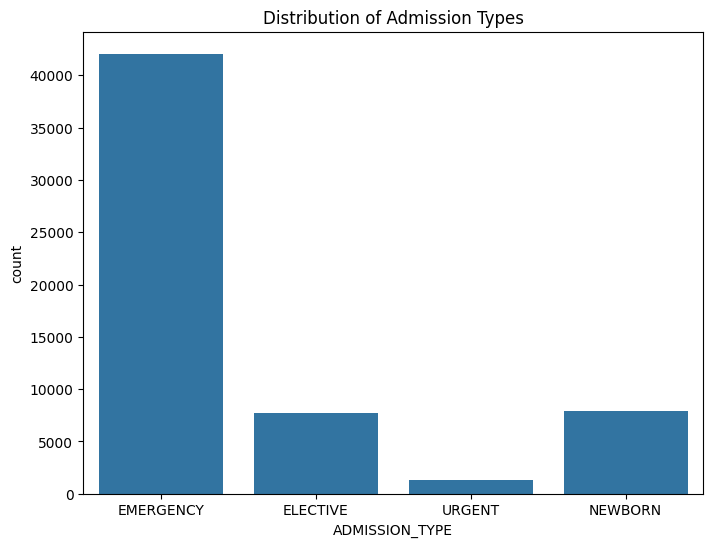

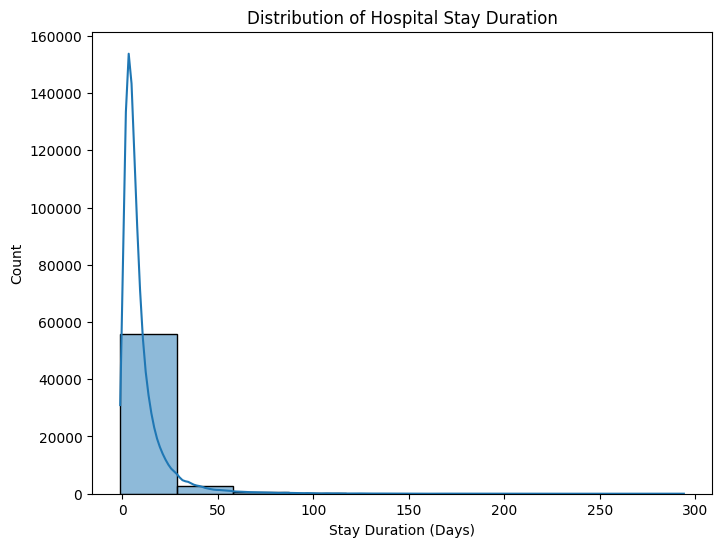

In [ ]:
# Basic Information
print("Basic Information:")
print(admissions_data.info())

# Summary Statistics for Numerical Columns
print("\nSummary Statistics:")
print(admissions_data.describe())

# Check for Missing Values
print("\nMissing Values:")
print(admissions_data.isnull().sum())

# Distribution of Admission Types
plt.figure(figsize=(8, 6))
sns.countplot(x='ADMISSION_TYPE', data=admissions_data)
plt.title('Distribution of Admission Types')
plt.show()

# Hospital Stay Duration (in days)
admissions_data['HOSPITAL_STAY_DAYS'] = (admissions_data['DISCHTIME'] - admissions_data['ADMITTIME']).dt.days
plt.figure(figsize=(8, 6))
sns.histplot(admissions_data['HOSPITAL_STAY_DAYS'], bins=10, kde=True)
plt.title('Distribution of Hospital Stay Duration')
plt.xlabel('Stay Duration (Days)')
plt.ylabel('Count')
plt.show()

##Clustering

In [ ]:
import pandas as pd
#Merging patient and admisson data for clustering
clustering_data = pd.merge(admissions_data, patient_data, on='SUBJECT_ID')
clustering_data

ROW_ID_x  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0         40230       41420   143206 2147-01-06 16:57:00 2147-01-08 18:30:00   
1         45890       58899   177890 2102-04-04 08:12:00 2102-04-10 16:00:00   
2         45891       58899   128162 2103-06-18 23:10:00 2103-06-27 12:12:00   
3         30863       25251   142346 2167-01-23 16:23:00 2167-02-06 13:53:00   
4         30864       25251   113851 2167-03-31 13:53:00 2167-04-07 14:47:00   
...         ...         ...      ...                 ...                 ...   
58971     37109       30481   158281 2151-12-28 22:58:00 2152-01-02 14:05:00   
58972     14732       11983   129454 2138-08-14 14:12:00 2138-08-14 12:00:00   
58973     11396        9314   104519 2192-03-19 13:42:00 2192-03-20 19:00:00   
58974     54130       84694   149446 2173-03-20 20:01:00 2173-03-23 22:25:00   
58975     45558       58016   105567 2118-10-08 20:59:00 2118-10-11 09:02:00   

      DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0           NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
1           NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
2           NaT      EMERGENCY  CLINIC REFERRAL/PREMATURE   
3           NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
4           NaT       ELECTIVE  TRANSFER FROM SKILLED NUR   
...         ...            ...                        ...   
58971       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58972       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58973       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58974       NaT         URGENT  TRANSFER FROM HOSP/EXTRAM   
58975       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

              DISCHARGE_LOCATION INSURANCE  ... HOSPITAL_EXPIRE_FLAG  \
0                            ICF  Medicare  ...                    0   
1                            ICF  Medicare  ...                    0   
2                            SNF  Medicare  ...                    0   
3                            ICF  Medicare  ...                    0   
4                            SNF  Medicare  ...                    0   
...                          ...       ...  ...                  ...   
58971  LEFT AGAINST MEDICAL ADVI  Medicare  ...                    0   
58972  LEFT AGAINST MEDICAL ADVI   Private  ...                    0   
58973  LEFT AGAINST MEDICAL ADVI   Private  ...                    0   
58974  LEFT AGAINST MEDICAL ADVI  Medicare  ...                    0   
58975  LEFT AGAINST MEDICAL ADVI  Medicaid  ...                    0   

      HAS_CHARTEVENTS_DATA HOSPITAL_STAY_DAYS ROW_ID_y GENDER        DOB  \
0                        1                  2    31177      F 1847-01-06   
1                        1                  6    35814      F 1802-04-04   
2                        1                  8    35814      F 1802-04-04   
3                        1                 13    23833      M 2096-08-27   
4                        0                  7    23833      M 2096-08-27   
...                    ...                ...      ...    ...        ...   
58971                    1                  4    28649      M 2103-06-18   
58972                    1                 -1    11340      M 2111-04-05   
58973                    1                  1     8813      F 2159-07-27   
58974                    1                  3    42552      M 2131-04-14   
58975                    1                  2    35555      M 2070-06-16   

             DOD  DOD_HOSP    DOD_SSN  EXPIRE_FLAG  
0            NaT       NaT        NaT            0  
1     2103-10-20       NaT 2103-10-20            1  
2     2103-10-20       NaT 2103-10-20            1  
3            NaT       NaT        NaT            0  
4            NaT       NaT        NaT            0  
...          ...       ...        ...          ...  
58971        NaT       NaT        NaT            0  
58972        NaT       NaT        NaT            0  
58973        NaT       NaT        NaT            0  
58974

In [ ]:
import pandas as pd
#Merging patient and admisson data for clustering
clustering_data = pd.merge(admissions_data, patient_data, on='SUBJECT_ID')
clustering_data

ROW_ID_x  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0         40230       41420   143206 2147-01-06 16:57:00 2147-01-08 18:30:00   
1         45890       58899   177890 2102-04-04 08:12:00 2102-04-10 16:00:00   
2         45891       58899   128162 2103-06-18 23:10:00 2103-06-27 12:12:00   
3         30863       25251   142346 2167-01-23 16:23:00 2167-02-06 13:53:00   
4         30864       25251   113851 2167-03-31 13:53:00 2167-04-07 14:47:00   
...         ...         ...      ...                 ...                 ...   
58971     37109       30481   158281 2151-12-28 22:58:00 2152-01-02 14:05:00   
58972     14732       11983   129454 2138-08-14 14:12:00 2138-08-14 12:00:00   
58973     11396        9314   104519 2192-03-19 13:42:00 2192-03-20 19:00:00   
58974     54130       84694   149446 2173-03-20 20:01:00 2173-03-23 22:25:00   
58975     45558       58016   105567 2118-10-08 20:59:00 2118-10-11 09:02:00   

      DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0           NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
1           NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
2           NaT      EMERGENCY  CLINIC REFERRAL/PREMATURE   
3           NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
4           NaT       ELECTIVE  TRANSFER FROM SKILLED NUR   
...         ...            ...                        ...   
58971       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58972       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58973       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58974       NaT         URGENT  TRANSFER FROM HOSP/EXTRAM   
58975       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

              DISCHARGE_LOCATION INSURANCE  ... HOSPITAL_EXPIRE_FLAG  \
0                            ICF  Medicare  ...                    0   
1                            ICF  Medicare  ...                    0   
2                            SNF  Medicare  ...                    0   
3                            ICF  Medicare  ...                    0   
4                            SNF  Medicare  ...                    0   
...                          ...       ...  ...                  ...   
58971  LEFT AGAINST MEDICAL ADVI  Medicare  ...                    0   
58972  LEFT AGAINST MEDICAL ADVI   Private  ...                    0   
58973  LEFT AGAINST MEDICAL ADVI   Private  ...                    0   
58974  LEFT AGAINST MEDICAL ADVI  Medicare  ...                    0   
58975  LEFT AGAINST MEDICAL ADVI  Medicaid  ...                    0   

      HAS_CHARTEVENTS_DATA HOSPITAL_STAY_DAYS ROW_ID_y GENDER        DOB  \
0                        1                  2    31177      F 1847-01-06   
1                        1                  6    35814      F 1802-04-04   
2                        1                  8    35814      F 1802-04-04   
3                        1                 13    23833      M 2096-08-27   
4                        0                  7    23833      M 2096-08-27   
...                    ...                ...      ...    ...        ...   
58971                    1                  4    28649      M 2103-06-18   
58972                    1                 -1    11340      M 2111-04-05   
58973                    1                  1     8813      F 2159-07-27   
58974                    1                  3    42552      M 2131-04-14   
58975                    1                  2    35555      M 2070-06-16   

             DOD  DOD_HOSP    DOD_SSN  EXPIRE_FLAG  
0            NaT       NaT        NaT            0  
1     2103-10-20       NaT 2103-10-20            1  
2     2103-10-20       NaT 2103-10-20            1  
3            NaT       NaT        NaT            0  
4            NaT       NaT        NaT            0  
...          ...       ...        ...          ...  
58971        NaT       NaT        NaT            0  
58972        NaT       NaT        NaT            0  
58973        NaT       NaT        NaT            0  
58974

In [ ]:
clustering_data.columns

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'HOSPITAL_STAY_DAYS',
       'ROW_ID_y', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

###Cluster Analysis - KMeans

In [ ]:
#Importing Libraries for Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
relevant_columns = ['ADMISSION_TYPE','ADMISSION_LOCATION','DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY','GENDER', 'EXPIRE_FLAG']
clustering_wo_text = clustering_data[relevant_columns]

### Checking for missing values

In [ ]:
clustering_wo_text.isna().sum()

ADMISSION_TYPE        0
ADMISSION_LOCATION    0
DISCHARGE_LOCATION    0
INSURANCE             0
ETHNICITY             0
GENDER                0
EXPIRE_FLAG           0
dtype: int64

We see that marital status has 10,128 missing values and since this is a categorical variable we can't replace it with mean/median. It would be better to drop this column completely.

In [ ]:
#Performing one-hot encoding for data that is non-numeric
clustering_data_encoded = pd.get_dummies(clustering_wo_text, columns=['ADMISSION_TYPE','ADMISSION_LOCATION','DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY', 'GENDER', 'EXPIRE_FLAG'])


In [ ]:
clustering_data_encoded.shape

(58976, 80)

In [ ]:
#Dimensionality Reduction with PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(clustering_data_encoded)

In [ ]:
pca_result.shape

(58976, 5)

In [ ]:
#Explaining the variance in PCA reduction
explained_variance = pca.explained_variance_ratio_
print("The principal components explain ",round(explained_variance.sum()*100),"% of the data")

The principal components explain  71 % of the data


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

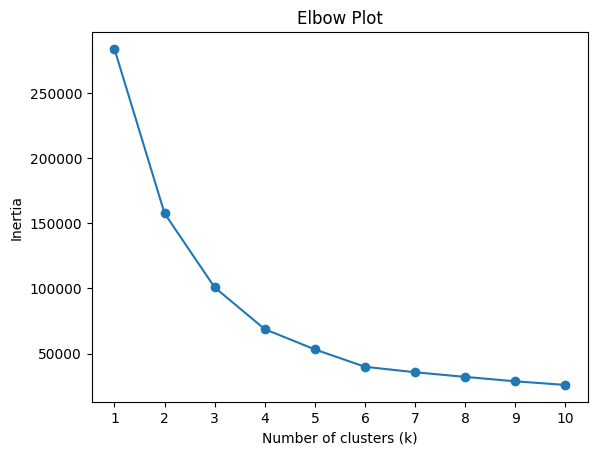

In [ ]:
# Initialize a list to store the inertia (sum of squared distances) for each value of k
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.xticks(k_values)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.express as px

# K-means Clustering with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(pca_result)

clustering_data_encoded['Cluster'] = kmeans.labels_

# Creating a scatter plot
fig = px.scatter_3d(x=pca_result[:, 0], y=pca_result[:, 1], z=pca_result[:, 2], color=kmeans.labels_,
                    labels={'x': 'Principal Component 1', 'y': 'Principal Component 2', 'z': 'Principal Component 3'},
                    title='K-means Clustering with PCA (K=6)',
                    color_continuous_scale=px.colors.sequential.Viridis)

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2).fit_transform(pca_result)

# K-means Clustering with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(pca_result)

clustering_data_encoded['Cluster'] = kmeans.labels_

#Creating a 2D scatter plot
fig = px.scatter(x=pca_2d[:, 0], y=pca_2d[:, 1], color=kmeans.labels_,
                 labels={'x': 'Principal Component 1', 'y': 'Principal Component 2'},
                 title='K-means Clustering with PCA (K=6)',
                 color_continuous_scale=px.colors.sequential.Viridis)

fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
clustering_data['Cluster'] = kmeans.labels_

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame

cluster_profiles = clustering_data.groupby('Cluster').agg({
    'ADMISSION_TYPE': lambda x: x.value_counts().index[0],  # Most common admission type
    'ADMISSION_LOCATION': lambda x: x.value_counts().index[0],  # Most common admission location
    'DISCHARGE_LOCATION': lambda x: x.value_counts().index[0],  # Most common discharge location
    'INSURANCE': lambda x: x.value_counts().index[0],  # Most common insurance type
    'ETHNICITY': lambda x: x.value_counts().index[0],  # Most common ethnicity
    'GENDER': lambda x: x.value_counts().index[0],  # Most common gender
    'EXPIRE_FLAG': 'mean',  # Average expire flag (could indicate mortality rate within the cluster)
    'DIAGNOSIS': lambda x: x.value_counts().index[0],  # Most common diagnosis
    'HOSPITAL_STAY_DAYS': 'mean',  # Average hospital stay in days
}).reset_index()

# Rename the columns for clarity
cluster_profiles.columns = [
    'Cluster', 'Common Admission Type', 'Common Admission Location', 'Common Discharge Location',
    'Common Insurance', 'Common Ethnicity', 'Common Gender', 'Average Expire Flag',
    'Common Diagnosis', 'Average Hospital Stay Days'
]

cluster_profiles

Cluster Common Admission Type  Common Admission Location  \
0        0             EMERGENCY       EMERGENCY ROOM ADMIT   
1        1             EMERGENCY       EMERGENCY ROOM ADMIT   
2        2               NEWBORN  PHYS REFERRAL/NORMAL DELI   
3        3             EMERGENCY       EMERGENCY ROOM ADMIT   
4        4               NEWBORN  PHYS REFERRAL/NORMAL DELI   
5        5             EMERGENCY       EMERGENCY ROOM ADMIT   

  Common Discharge Location Common Insurance Common Ethnicity Common Gender  \
0                      HOME         Medicare            WHITE             F   
1                      HOME          Private            WHITE             M   
2                      HOME          Private            WHITE             F   
3              DEAD/EXPIRED         Medicare            WHITE             F   
4                      HOME          Private            WHITE             M   
5              DEAD/EXPIRED         Medicare            WHITE             M   

   Average Expire Flag         Common Diagnosis  Average Hospital Stay Days  
0                  0.0                PNEUMONIA                    8.528404  
1             0.010357  CORONARY ARTERY DISEASE                    8.859590  
2             0.066827                  NEWBORN                    9.743055  
3                  1.0                PNEUMONIA                   10.334899  
4             0.098572                  NEWBORN                    9.298572  
5                  1.0                PNEUMONIA                   10.911397

In [ ]:
cluster_sizes = clustering_data.groupby('Cluster').size()
cluster_sizes_df = cluster_sizes.reset_index(name='Size')
cluster_sizes_df.columns = ['Cluster', 'Total_Count']

print(cluster_sizes_df)

   Cluster  Total_Count
0        0         9576
1        1        12841
2        2         6659
3        3         9791
4        4         8755
5        5        11354


# Cluster Profiles Summary

## Cluster 0
- **Admission Type**: Primarily emergency cases.
- **Admission Location**: Patients are mainly admitted through the emergency room.
- **Discharge Location**: Most patients are discharged to their homes.
- **Insurance**: Most patients are covered by Medicare.
- **Ethnicity**: The predominant ethnicity is White.
- **Gender**: The majority of patients in this cluster are female.
- **Average Expire Flag**: The mortality rate within this cluster is 0, indicating no deaths recorded.
- **Common Diagnosis**: Pneumonia is the most frequent diagnosis.
- **Average Hospital Stay Days**: The average length of hospital stay is approximately 8.5 days.

## Cluster 1
- **Admission Type**: Mainly emergency admissions.
- **Admission Location**: Patients typically come from the emergency room.
- **Discharge Location**: Patients are generally discharged to their homes.
- **Insurance**: Private insurance is the most common.
- **Ethnicity**: Predominantly White.
- **Gender**: Mostly male patients.
- **Average Expire Flag**: Low mortality rate, close to 0, but slightly higher than Cluster 0.
- **Common Diagnosis**: The most common diagnosis is coronary artery disease.
- **Average Hospital Stay Days**: Patients stay in the hospital for nearly 8.9 days on average.

## Cluster 2
- **Admission Type**: Largely newborns admitted.
- **Admission Location**: Admission typically follows a physician referral after a normal delivery.
- **Discharge Location**: Newborns are usually discharged home.
- **Insurance**: The majority have private insurance.
- **Ethnicity**: Predominantly White.
- **Gender**: Female patients are more frequent in this cluster, which could correlate with the mothers of newborns.
- **Average Expire Flag**: Slightly higher mortality rate than Clusters 0 and 1, possibly reflecting complications related to childbirth or neonatal issues.
- **Common Diagnosis**: Newborns, indicating this cluster is likely representing maternity and neonatal care.
- **Average Hospital Stay Days**: The average stay is approximately 9.7 days, which may include the delivery and postpartum period.

## Cluster 3
- **Admission Type**: Emergency admissions.
- **Admission Location**: Patients are admitted through the emergency room.
- **Discharge Location**: The discharge status is "dead/expired," indicating a high mortality rate.
- **Insurance**: Medicare is the most common insurance type.
- **Ethnicity**: Predominantly White.
- **Gender**: Predominantly female.
- **Average Expire Flag**: The mortality rate is 1, which means all patients in this cluster have expired.
- **Common Diagnosis**: Pneumonia is the most common condition.
- **Average Hospital Stay Days**: The average length of stay is over 10 days.

## Cluster 4
- **Admission Type**: Newborn admissions.
- **Admission Location**: Similar to Cluster 2, with admissions following a physician referral after normal deliveries.
- **Discharge Location**: Discharge typically to home.
- **Insurance**: Primarily covered by private insurance.
- **Ethnicity**: Predominantly White.
- **Gender**: Mostly male, which could be newborns or possibly a data entry convention.
- **Average Expire Flag**: Slightly higher mortality rate, indicative of potential neonatal complications.
- **Common Diagnosis**: Newborns, focused on neonatal care.
- **Average Hospital Stay Days**: Around 9.3 days, likely covering both delivery and postnatal care.

## Cluster 5
- **Admission Type**: Emergency admissions.
- **Admission Location**: Admissions predominantly from the emergency room.
- **Discharge Location**: High mortality rate with the discharge status being "dead/expired."
- **Insurance**: Medicare is the most common insurance.
- **Ethnicity**: Predominantly White.
- **Gender**: Mostly male patients.
- **Average Expire Flag**: A mortality rate of 1, indicating all patients in the cluster have expired.
- **Common Diagnosis**: Pneumonia is the recurrent condition.
- **Average Hospital Stay Days**: The average stay is nearly 11 days, which is the longest among the clusters, potentially due to the severity of the conditions leading to mortality.

**Each cluster represents a different patient demographic and clinical outcome profile, from routine newborn care to emergency admissions with high mortality rates. The common diagnoses suggest focal points for care in each cluster, with pneumonia being a significant concern in clusters with higher mortality rates.**